In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from torch.autograd import Variable
import random
import matplotlib.pyplot as plt
import gluonnlp as nlp
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model
from gluonnlp.data import SentencepieceTokenizer
from sklearn.model_selection import train_test_split

# BERT Model 불러오기.
bertmodel, vocab = get_pytorch_kobert_model()

# 데이터 불러오기
Data = pd.read_csv('/Users/waterpurifier/TextClassification_CNN/Dataset-v2.csv', sep=',')
# train, test dataset 분리
dataset_train, dataset_test = train_test_split(Data, test_size=0.3, random_state=5555, stratify=Data['label'])
dataset_train.to_csv('/Users/waterpurifier/TextClassification_CNN/Dataset_train-v2.csv', sep='\t')
dataset_test.to_csv('/Users/waterpurifier/TextClassification_CNN/Dataset_test-v2.csv', sep='\t')
dataset_train = nlp.data.TSVDataset('/Users/waterpurifier/TextClassification_CNN/Dataset_train-v2.csv', encoding='utf-8', field_indices=[3,4], num_discard_samples=1)
dataset_test = nlp.data.TSVDataset('/Users/waterpurifier/TextClassification_CNN/Dataset_test-v2.csv', encoding='utf-8', field_indices=[3,4], num_discard_samples=1)

# tokenizer 불러오기
token_path = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(token_path, vocab, lower=False)

# BERTDataset input : Text, system : BERT model, tokenizer, output : vector
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len, pad, pair):

        transform = nlp.data.BERTSentenceTransform(bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)
        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]
        
        # 기존의 방식에서 model에 적용할 때 data type이 안맞아서 <list> (int) 로 맞췄음.
        self.sentences = [i[0].tolist() for i in self.sentences]
        self.labels = [i.tolist() for i in self.labels]
        
    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))
    
    def __len__(self):
        return (len(self.labels))
    
# padding
max_len = 50
vocab_size = len(vocab)

# bert model 적용.
data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)


using cached model
using cached model
using cached model


In [2]:
# pytorch model input Variable 변수로 변환 
def convert_to_long_variable(w2i_ls):
    return Variable(torch.LongTensor(w2i_ls))

# 학습 도중 데이터 분리를 위한 split 함수,
def datasetsplit(data, i):
    dataset_train, dataset_test = train_test_split(Data, test_size=0.3, random_state=5555 + i, stratify=Data['label'])
    dataset_train.to_csv('/Users/waterpurifier/TextClassification_CNN/Dataset_train-v2.csv', sep='\t')
    dataset_test.to_csv('/Users/waterpurifier/TextClassification_CNN/Dataset_test-v2.csv', sep='\t')
    dataset_train = nlp.data.TSVDataset('/Users/waterpurifier/TextClassification_CNN/Dataset_train-v2.csv', encoding='utf-8', field_indices=[3,4], num_discard_samples=1)
    dataset_test = nlp.data.TSVDataset('/Users/waterpurifier/TextClassification_CNN/Dataset_test-v2.csv', encoding='utf-8', field_indices=[3,4], num_discard_samples=1)
    data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
    data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)
    X_train = data_train.sentences
    Y_train = data_train.labels

    X_test = data_test.sentences
    Y_test = data_test.labels


    x_train = convert_to_long_variable(X_train)
    y_train = convert_to_long_variable(Y_train)

    x_test = convert_to_long_variable(X_test)
    y_test = convert_to_long_variable(Y_test)
    return x_train, y_train, x_test, y_test

# CNN Pytorch

In [4]:
class CNN_text(nn.Module):
    
    def __init__(self, n_words, embed_size, pad_index, hid_size, drop_rate, kernel_size_ls, num_filter, n_class):
        super(CNN_text, self).__init__()
        
        self.pad_index = pad_index              # 단어 embedding 과정에서 제외시킬 padding token
        self.embed_size = embed_size            # 임베딩 차원의 크기
        self.hid_size = hid_size                # 히든 레이어 갯수
        self.drop_rate = drop_rate              # 드롭아웃 비율
        self.num_filter = num_filter            # 필터의 갯수 
        self.kernel_size_ls = kernel_size_ls    # 각기 다른 필터 사이즈가 담긴 리스트
        self.num_kernel = len(kernel_size_ls)   # 필터 사이즈의 종류 수
        self.n_class = n_class                  # 카테고리 갯수
        
        self.embed = nn.Embedding(
            num_embeddings=n_words, 
            embedding_dim=embed_size,
            padding_idx=self.pad_index
        )
        
        
        # kernel size는 (n-gram, embed_size)이다.
        # 커널의 열(column)의 크기는 embed_size와 일치하므로, 단어 임베딩 벡터를 모두 커버한다.
        # 따라서, n의 row 크기를 갖는 커널은 한번에 n개의 단어를 커버하는 n-gram 커널이라고 볼 수 있다.
        self.convs = nn.ModuleList([nn.Conv1d(1, num_filter, (kernel_size, embed_size)) for kernel_size in kernel_size_ls])
        
        self.lin = nn.Sequential(
            nn.Linear(self.num_kernel*num_filter, hid_size), nn.ReLU(), nn.Dropout(drop_rate),
            nn.Linear(hid_size, n_class),
        )
        
    def forward(self, x):
        embed = self.embed(x) # batch_size x max_length x embed_size
        embed.unsqueeze_(1)       # batch_size, 1, max_length, embed_size : convolution을 위해 4D로 차원을 조절
        
        # convolution
        conved = [conv(embed).squeeze(3) for conv in self.convs] # [batch_size, num_filter, max_length -kernel_size +1]
        
        # max_pooling
        pooled = [F.max_pool1d(conv, (conv.size(2))).squeeze(2) for conv in conved] # [batch_size, num_kernel, num_filter]
            
        # dropout
        dropouted = [F.dropout(pool, self.drop_rate) for pool in pooled]
        
        # concatenate
        concated = torch.cat(dropouted, dim = 1) # [batch_size, num_kernel * num_filter]
        
        
        logit = self.lin(m(concated))
        
        return logit

In [5]:
params = {
    'n_words' : vocab_size,        # 고유한 단어 토큰의 갯수
    'embed_size' : 128,                # 임베딩 차원의 크기
    'pad_index' : max_len,  # 패딩 토큰
    'hid_size' : 100,                  # 히든 레이어 갯수
    'drop_rate' : 0.55,                 # 드롭아웃 비율  
    'kernel_size_ls' : [2,3,4],      # 커널 사이즈 리스트       
    'num_filter' : 16,                 # 각 사이즈 별 커널 갯수 
    'n_class' : 1,                  # 카테고리 갯수
}

In [6]:
model = CNN_text(**params)

In [7]:
epochs = 1000
# learning rate, 값이 커질수록 exp 증가
lr = 0.00025 
batch_size = 128*2

# data indexing
train_idx = np.arange(x_train.size(0))
test_idx = np.arange(x_test.size(0))

# Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(),lr)
# 손실 계산을 위한 Sigmoid, BCELoss
m = nn.Sigmoid()
criterion = nn.BCELoss()

# epoch에 따라 acc, loss 저장
train_loss_ls = []
train_acc_ls = []
test_loss_ls = []
test_acc_ls = []

for epoch in range(epochs):
    # 모델 학습
    model.train()
    # 10번마다 split 변경
    if epoch != 0:
        if epoch % 10 == 0:
            x_train, y_train, x_test, y_test = datasetsplit(Data, epoch)
            print('changed!', x_train[0], y_train[0])
    # input 데이터 순서 섞기
    random.shuffle(train_idx)
    x_train = x_train[train_idx]
    y_train = y_train[train_idx]
    
    # 손실 초기화
    train_loss = 0
    test_loss = 0
    
    for start_idx, end_idx in zip(range(0, x_train.size(0), batch_size),
                                  range(batch_size, x_train.size(0)+1, batch_size)):
        # batch size로 data split
        x_batch = x_train[start_idx : end_idx]
        y_batch = y_train[start_idx : end_idx].float()
        
        # score : train data에 대한 예측 
        scores = model(x_batch)
        # 0.5 보다 크면 부정적 댓글 '1', 0.5 보다 작으면 일반적 댓글 '0'
        predict = []
        for i in m(scores):
            if i > 0.5: 
                predict.append(1)
            else:
                predict.append(0)
        predict = convert_to_long_variable(predict)
        # acc 계산
        acc = (predict == y_batch).sum().item() / batch_size
        # loss 계산
        loss = criterion(m(scores), y_batch)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print('Train epoch : %s,  loss : %s,  accuracy :%.3f'%(epoch+1, train_loss / batch_size, acc))
    print('=================================================================================================')
    
    
    train_loss_ls.append(train_loss/batch_size)
    train_acc_ls.append(acc)
    if (epoch+1) % 1 == 0:
        model.eval()
        scores = model(x_test)
        #predict = F.softmax(scores, dim=1).argmax(dim = 1)
        predict = []
        for i in m(scores):
            if i > 0.5: 
                predict.append(1)
            else:
                predict.append(0)
        predict = convert_to_long_variable(predict)
        
        acc = (predict == y_test.long()).sum().item() / y_test.size(0)
        test_train_ls.append(acc)
        loss = criterion(m(scores), y_test.float())
        test_loss += loss.item()
        test_loss_ls.append(test_loss)
        print('*************************************************************************************************')
        print('*************************************************************************************************')
        print('Test Epoch : %s, Test Loss : %.03f , Test Accuracy : %.03f'%(epoch+1, test_loss/y_test.size(0), acc))
        print('*************************************************************************************************')
        print('*************************************************************************************************')


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 1,  loss : 0.25285812839865685,  accuracy :0.621


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 1, Test Loss : 0.000 , Test Accuracy : 0.658
*************************************************************************************************
*************************************************************************************************
Train epoch : 2,  loss : 0.24911034759134054,  accuracy :0.727
*************************************************************************************************
*************************************************************************************************
Test Epoch : 2, Test Loss : 0.000 , Test Accuracy : 0.658
*************************************************************************************************
*************************************************************************************************
Train epoch : 3,  loss : 0.2437917452

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 11,  loss : 0.1096468279720284,  accuracy :0.910


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 11, Test Loss : 0.000 , Test Accuracy : 0.901
*************************************************************************************************
*************************************************************************************************
Train epoch : 12,  loss : 0.10185536148492247,  accuracy :0.914
*************************************************************************************************
*************************************************************************************************
Test Epoch : 12, Test Loss : 0.000 , Test Accuracy : 0.905
*************************************************************************************************
*************************************************************************************************
Train epoch : 13,  loss : 0.095123

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 21,  loss : 0.07102103292709216,  accuracy :0.891


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 21, Test Loss : 0.000 , Test Accuracy : 0.935
*************************************************************************************************
*************************************************************************************************
Train epoch : 22,  loss : 0.06655931335990317,  accuracy :0.957
*************************************************************************************************
*************************************************************************************************
Test Epoch : 22, Test Loss : 0.000 , Test Accuracy : 0.933
*************************************************************************************************
*************************************************************************************************
Train epoch : 23,  loss : 0.064023

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 31,  loss : 0.056325742130866274,  accuracy :0.973


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 31, Test Loss : 0.000 , Test Accuracy : 0.952
*************************************************************************************************
*************************************************************************************************
Train epoch : 32,  loss : 0.05308931408217177,  accuracy :0.949
*************************************************************************************************
*************************************************************************************************
Test Epoch : 32, Test Loss : 0.000 , Test Accuracy : 0.948
*************************************************************************************************
*************************************************************************************************
Train epoch : 33,  loss : 0.052241

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 41,  loss : 0.04716671910136938,  accuracy :0.977


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 41, Test Loss : 0.000 , Test Accuracy : 0.958
*************************************************************************************************
*************************************************************************************************
Train epoch : 42,  loss : 0.044646737034781836,  accuracy :0.961
*************************************************************************************************
*************************************************************************************************
Test Epoch : 42, Test Loss : 0.000 , Test Accuracy : 0.955
*************************************************************************************************
*************************************************************************************************
Train epoch : 43,  loss : 0.04234

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 51,  loss : 0.04028033569920808,  accuracy :0.961


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 51, Test Loss : 0.000 , Test Accuracy : 0.966
*************************************************************************************************
*************************************************************************************************
Train epoch : 52,  loss : 0.03890037161181681,  accuracy :0.957
*************************************************************************************************
*************************************************************************************************
Test Epoch : 52, Test Loss : 0.000 , Test Accuracy : 0.965
*************************************************************************************************
*************************************************************************************************
Train epoch : 53,  loss : 0.037460

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 61,  loss : 0.0365965329692699,  accuracy :0.992


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 61, Test Loss : 0.000 , Test Accuracy : 0.973
*************************************************************************************************
*************************************************************************************************
Train epoch : 62,  loss : 0.03497126187721733,  accuracy :0.980
*************************************************************************************************
*************************************************************************************************
Test Epoch : 62, Test Loss : 0.000 , Test Accuracy : 0.973
*************************************************************************************************
*************************************************************************************************
Train epoch : 63,  loss : 0.034081

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 71,  loss : 0.030855324410367757,  accuracy :0.977


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 71, Test Loss : 0.000 , Test Accuracy : 0.971
*************************************************************************************************
*************************************************************************************************
Train epoch : 72,  loss : 0.02995759600889869,  accuracy :0.973
*************************************************************************************************
*************************************************************************************************
Test Epoch : 72, Test Loss : 0.000 , Test Accuracy : 0.971
*************************************************************************************************
*************************************************************************************************
Train epoch : 73,  loss : 0.028406

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 81,  loss : 0.029485312988981605,  accuracy :0.988


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 81, Test Loss : 0.000 , Test Accuracy : 0.975
*************************************************************************************************
*************************************************************************************************
Train epoch : 82,  loss : 0.02731860365747707,  accuracy :0.980
*************************************************************************************************
*************************************************************************************************
Test Epoch : 82, Test Loss : 0.000 , Test Accuracy : 0.975
*************************************************************************************************
*************************************************************************************************
Train epoch : 83,  loss : 0.026489

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 91,  loss : 0.027079217092250474,  accuracy :0.973


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 91, Test Loss : 0.000 , Test Accuracy : 0.974
*************************************************************************************************
*************************************************************************************************
Train epoch : 92,  loss : 0.024486568458087277,  accuracy :0.980
*************************************************************************************************
*************************************************************************************************
Test Epoch : 92, Test Loss : 0.000 , Test Accuracy : 0.975
*************************************************************************************************
*************************************************************************************************
Train epoch : 93,  loss : 0.02426

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 101,  loss : 0.024974873595056124,  accuracy :0.980


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 101, Test Loss : 0.000 , Test Accuracy : 0.980
*************************************************************************************************
*************************************************************************************************
Train epoch : 102,  loss : 0.02379787993413629,  accuracy :0.992
*************************************************************************************************
*************************************************************************************************
Test Epoch : 102, Test Loss : 0.000 , Test Accuracy : 0.978
*************************************************************************************************
*************************************************************************************************
Train epoch : 103,  loss : 0.02

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 111,  loss : 0.023557291911856737,  accuracy :0.977


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 111, Test Loss : 0.000 , Test Accuracy : 0.982
*************************************************************************************************
*************************************************************************************************
Train epoch : 112,  loss : 0.022781510386266746,  accuracy :0.980
*************************************************************************************************
*************************************************************************************************
Test Epoch : 112, Test Loss : 0.000 , Test Accuracy : 0.978
*************************************************************************************************
*************************************************************************************************
Train epoch : 113,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 121,  loss : 0.021981352259899722,  accuracy :0.988


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 121, Test Loss : 0.000 , Test Accuracy : 0.979
*************************************************************************************************
*************************************************************************************************
Train epoch : 122,  loss : 0.021132014680915745,  accuracy :0.965
*************************************************************************************************
*************************************************************************************************
Test Epoch : 122, Test Loss : 0.000 , Test Accuracy : 0.981
*************************************************************************************************
*************************************************************************************************
Train epoch : 123,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 131,  loss : 0.020951644091837807,  accuracy :0.977


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 131, Test Loss : 0.000 , Test Accuracy : 0.982
*************************************************************************************************
*************************************************************************************************
Train epoch : 132,  loss : 0.0199419599812245,  accuracy :0.996
*************************************************************************************************
*************************************************************************************************
Test Epoch : 132, Test Loss : 0.000 , Test Accuracy : 0.983
*************************************************************************************************
*************************************************************************************************
Train epoch : 133,  loss : 0.019

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 141,  loss : 0.019784664717008127,  accuracy :0.984


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 141, Test Loss : 0.000 , Test Accuracy : 0.983
*************************************************************************************************
*************************************************************************************************
Train epoch : 142,  loss : 0.018955338251544163,  accuracy :0.988
*************************************************************************************************
*************************************************************************************************
Test Epoch : 142, Test Loss : 0.000 , Test Accuracy : 0.982
*************************************************************************************************
*************************************************************************************************
Train epoch : 143,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 151,  loss : 0.02003030613195733,  accuracy :0.984


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 151, Test Loss : 0.000 , Test Accuracy : 0.983
*************************************************************************************************
*************************************************************************************************
Train epoch : 152,  loss : 0.017988633313507307,  accuracy :0.977
*************************************************************************************************
*************************************************************************************************
Test Epoch : 152, Test Loss : 0.000 , Test Accuracy : 0.985
*************************************************************************************************
*************************************************************************************************
Train epoch : 153,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 161,  loss : 0.017280265266890638,  accuracy :0.996


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 161, Test Loss : 0.000 , Test Accuracy : 0.984
*************************************************************************************************
*************************************************************************************************
Train epoch : 162,  loss : 0.016772586644947296,  accuracy :0.988
*************************************************************************************************
*************************************************************************************************
Test Epoch : 162, Test Loss : 0.000 , Test Accuracy : 0.983
*************************************************************************************************
*************************************************************************************************
Train epoch : 163,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 171,  loss : 0.017607820605917368,  accuracy :0.992


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 171, Test Loss : 0.000 , Test Accuracy : 0.984
*************************************************************************************************
*************************************************************************************************
Train epoch : 172,  loss : 0.016764890651757014,  accuracy :0.980
*************************************************************************************************
*************************************************************************************************
Test Epoch : 172, Test Loss : 0.000 , Test Accuracy : 0.985
*************************************************************************************************
*************************************************************************************************
Train epoch : 173,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 181,  loss : 0.0161273169942433,  accuracy :0.980


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 181, Test Loss : 0.000 , Test Accuracy : 0.986
*************************************************************************************************
*************************************************************************************************
Train epoch : 182,  loss : 0.014689046885905555,  accuracy :0.992
*************************************************************************************************
*************************************************************************************************
Test Epoch : 182, Test Loss : 0.000 , Test Accuracy : 0.987
*************************************************************************************************
*************************************************************************************************
Train epoch : 183,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 191,  loss : 0.016113492445583688,  accuracy :0.984


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 191, Test Loss : 0.000 , Test Accuracy : 0.988
*************************************************************************************************
*************************************************************************************************
Train epoch : 192,  loss : 0.016338975470716832,  accuracy :0.969
*************************************************************************************************
*************************************************************************************************
Test Epoch : 192, Test Loss : 0.000 , Test Accuracy : 0.985
*************************************************************************************************
*************************************************************************************************
Train epoch : 193,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 201,  loss : 0.01557088171466603,  accuracy :0.984


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 201, Test Loss : 0.000 , Test Accuracy : 0.989
*************************************************************************************************
*************************************************************************************************
Train epoch : 202,  loss : 0.014759413486899575,  accuracy :0.996
*************************************************************************************************
*************************************************************************************************
Test Epoch : 202, Test Loss : 0.000 , Test Accuracy : 0.989
*************************************************************************************************
*************************************************************************************************
Train epoch : 203,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 211,  loss : 0.015356335214164574,  accuracy :0.988


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 211, Test Loss : 0.000 , Test Accuracy : 0.988
*************************************************************************************************
*************************************************************************************************
Train epoch : 212,  loss : 0.015255982503731502,  accuracy :0.973
*************************************************************************************************
*************************************************************************************************
Test Epoch : 212, Test Loss : 0.000 , Test Accuracy : 0.989
*************************************************************************************************
*************************************************************************************************
Train epoch : 213,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 221,  loss : 0.014471435089944862,  accuracy :0.980


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 221, Test Loss : 0.000 , Test Accuracy : 0.988
*************************************************************************************************
*************************************************************************************************
Train epoch : 222,  loss : 0.012514064614151721,  accuracy :0.988
*************************************************************************************************
*************************************************************************************************
Test Epoch : 222, Test Loss : 0.000 , Test Accuracy : 0.989
*************************************************************************************************
*************************************************************************************************
Train epoch : 223,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 231,  loss : 0.015637549142411444,  accuracy :0.988


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 231, Test Loss : 0.000 , Test Accuracy : 0.989
*************************************************************************************************
*************************************************************************************************
Train epoch : 232,  loss : 0.013521366639906773,  accuracy :0.984
*************************************************************************************************
*************************************************************************************************
Test Epoch : 232, Test Loss : 0.000 , Test Accuracy : 0.989
*************************************************************************************************
*************************************************************************************************
Train epoch : 233,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 241,  loss : 0.013496407016646117,  accuracy :0.996


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 241, Test Loss : 0.000 , Test Accuracy : 0.989
*************************************************************************************************
*************************************************************************************************
Train epoch : 242,  loss : 0.012660291342399432,  accuracy :1.000
*************************************************************************************************
*************************************************************************************************
Test Epoch : 242, Test Loss : 0.000 , Test Accuracy : 0.989
*************************************************************************************************
*************************************************************************************************
Train epoch : 243,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 251,  loss : 0.012750476847941172,  accuracy :0.996


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 251, Test Loss : 0.000 , Test Accuracy : 0.988
*************************************************************************************************
*************************************************************************************************
Train epoch : 252,  loss : 0.012815595699066762,  accuracy :0.984
*************************************************************************************************
*************************************************************************************************
Test Epoch : 252, Test Loss : 0.000 , Test Accuracy : 0.988
*************************************************************************************************
*************************************************************************************************
Train epoch : 253,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 261,  loss : 0.011960183594055707,  accuracy :0.992


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 261, Test Loss : 0.000 , Test Accuracy : 0.990
*************************************************************************************************
*************************************************************************************************
Train epoch : 262,  loss : 0.01162187668523984,  accuracy :0.992
*************************************************************************************************
*************************************************************************************************
Test Epoch : 262, Test Loss : 0.000 , Test Accuracy : 0.987
*************************************************************************************************
*************************************************************************************************
Train epoch : 263,  loss : 0.01

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 271,  loss : 0.012732055842207046,  accuracy :0.996


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 271, Test Loss : 0.000 , Test Accuracy : 0.991
*************************************************************************************************
*************************************************************************************************
Train epoch : 272,  loss : 0.01173160714097321,  accuracy :0.992
*************************************************************************************************
*************************************************************************************************
Test Epoch : 272, Test Loss : 0.000 , Test Accuracy : 0.989
*************************************************************************************************
*************************************************************************************************
Train epoch : 273,  loss : 0.01

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 281,  loss : 0.012381632695905864,  accuracy :0.992


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 281, Test Loss : 0.000 , Test Accuracy : 0.991
*************************************************************************************************
*************************************************************************************************
Train epoch : 282,  loss : 0.012018497947792639,  accuracy :0.988
*************************************************************************************************
*************************************************************************************************
Test Epoch : 282, Test Loss : 0.000 , Test Accuracy : 0.988
*************************************************************************************************
*************************************************************************************************
Train epoch : 283,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 291,  loss : 0.01147783580563555,  accuracy :0.992


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 291, Test Loss : 0.000 , Test Accuracy : 0.991
*************************************************************************************************
*************************************************************************************************
Train epoch : 292,  loss : 0.011230403622903395,  accuracy :0.984
*************************************************************************************************
*************************************************************************************************
Test Epoch : 292, Test Loss : 0.000 , Test Accuracy : 0.989
*************************************************************************************************
*************************************************************************************************
Train epoch : 293,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 301,  loss : 0.011680014582452714,  accuracy :1.000


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 301, Test Loss : 0.000 , Test Accuracy : 0.989
*************************************************************************************************
*************************************************************************************************
Train epoch : 302,  loss : 0.01091176840782282,  accuracy :1.000
*************************************************************************************************
*************************************************************************************************
Test Epoch : 302, Test Loss : 0.000 , Test Accuracy : 0.990
*************************************************************************************************
*************************************************************************************************
Train epoch : 303,  loss : 0.00

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 311,  loss : 0.012172225777248968,  accuracy :0.992


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 311, Test Loss : 0.000 , Test Accuracy : 0.992
*************************************************************************************************
*************************************************************************************************
Train epoch : 312,  loss : 0.011222653363802237,  accuracy :0.984
*************************************************************************************************
*************************************************************************************************
Test Epoch : 312, Test Loss : 0.000 , Test Accuracy : 0.990
*************************************************************************************************
*************************************************************************************************
Train epoch : 313,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 321,  loss : 0.01014617578675825,  accuracy :0.988


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 321, Test Loss : 0.000 , Test Accuracy : 0.990
*************************************************************************************************
*************************************************************************************************
Train epoch : 322,  loss : 0.010452878923388198,  accuracy :0.996
*************************************************************************************************
*************************************************************************************************
Test Epoch : 322, Test Loss : 0.000 , Test Accuracy : 0.989
*************************************************************************************************
*************************************************************************************************
Train epoch : 323,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 331,  loss : 0.011869809130075737,  accuracy :0.992


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 331, Test Loss : 0.000 , Test Accuracy : 0.991
*************************************************************************************************
*************************************************************************************************
Train epoch : 332,  loss : 0.010731706488513737,  accuracy :0.992
*************************************************************************************************
*************************************************************************************************
Test Epoch : 332, Test Loss : 0.000 , Test Accuracy : 0.990
*************************************************************************************************
*************************************************************************************************
Train epoch : 333,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 341,  loss : 0.011019390120054595,  accuracy :0.996


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 341, Test Loss : 0.000 , Test Accuracy : 0.992
*************************************************************************************************
*************************************************************************************************
Train epoch : 342,  loss : 0.010113664608070394,  accuracy :0.988
*************************************************************************************************
*************************************************************************************************
Test Epoch : 342, Test Loss : 0.000 , Test Accuracy : 0.991
*************************************************************************************************
*************************************************************************************************
Train epoch : 343,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 351,  loss : 0.010026944005403493,  accuracy :0.992


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 351, Test Loss : 0.000 , Test Accuracy : 0.991
*************************************************************************************************
*************************************************************************************************
Train epoch : 352,  loss : 0.010017242835601792,  accuracy :0.992
*************************************************************************************************
*************************************************************************************************
Test Epoch : 352, Test Loss : 0.000 , Test Accuracy : 0.992
*************************************************************************************************
*************************************************************************************************
Train epoch : 353,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 361,  loss : 0.010585990270556067,  accuracy :0.992


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 361, Test Loss : 0.000 , Test Accuracy : 0.990
*************************************************************************************************
*************************************************************************************************
Train epoch : 362,  loss : 0.009904058453685138,  accuracy :1.000
*************************************************************************************************
*************************************************************************************************
Test Epoch : 362, Test Loss : 0.000 , Test Accuracy : 0.992
*************************************************************************************************
*************************************************************************************************
Train epoch : 363,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 371,  loss : 0.009603397538739955,  accuracy :0.996


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 371, Test Loss : 0.000 , Test Accuracy : 0.991
*************************************************************************************************
*************************************************************************************************
Train epoch : 372,  loss : 0.008976527543381962,  accuracy :0.988
*************************************************************************************************
*************************************************************************************************
Test Epoch : 372, Test Loss : 0.000 , Test Accuracy : 0.991
*************************************************************************************************
*************************************************************************************************
Train epoch : 373,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 381,  loss : 0.009427699520529131,  accuracy :0.984


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 381, Test Loss : 0.000 , Test Accuracy : 0.992
*************************************************************************************************
*************************************************************************************************
Train epoch : 382,  loss : 0.009694807240521186,  accuracy :0.988
*************************************************************************************************
*************************************************************************************************
Test Epoch : 382, Test Loss : 0.000 , Test Accuracy : 0.993
*************************************************************************************************
*************************************************************************************************
Train epoch : 383,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 391,  loss : 0.008414828138484154,  accuracy :0.992


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 391, Test Loss : 0.000 , Test Accuracy : 0.991
*************************************************************************************************
*************************************************************************************************
Train epoch : 392,  loss : 0.009279321924623218,  accuracy :1.000
*************************************************************************************************
*************************************************************************************************
Test Epoch : 392, Test Loss : 0.000 , Test Accuracy : 0.992
*************************************************************************************************
*************************************************************************************************
Train epoch : 393,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 401,  loss : 0.009031599351146724,  accuracy :0.996


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 401, Test Loss : 0.000 , Test Accuracy : 0.992
*************************************************************************************************
*************************************************************************************************
Train epoch : 402,  loss : 0.00879568901109451,  accuracy :0.992
*************************************************************************************************
*************************************************************************************************
Test Epoch : 402, Test Loss : 0.000 , Test Accuracy : 0.993
*************************************************************************************************
*************************************************************************************************
Train epoch : 403,  loss : 0.00

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 411,  loss : 0.009487775251727726,  accuracy :0.996


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 411, Test Loss : 0.000 , Test Accuracy : 0.993
*************************************************************************************************
*************************************************************************************************
Train epoch : 412,  loss : 0.009831190371187404,  accuracy :0.988
*************************************************************************************************
*************************************************************************************************
Test Epoch : 412, Test Loss : 0.000 , Test Accuracy : 0.992
*************************************************************************************************
*************************************************************************************************
Train epoch : 413,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 421,  loss : 0.008687206309332396,  accuracy :0.988


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 421, Test Loss : 0.000 , Test Accuracy : 0.993
*************************************************************************************************
*************************************************************************************************
Train epoch : 422,  loss : 0.008453796801404678,  accuracy :0.984
*************************************************************************************************
*************************************************************************************************
Test Epoch : 422, Test Loss : 0.000 , Test Accuracy : 0.991
*************************************************************************************************
*************************************************************************************************
Train epoch : 423,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 431,  loss : 0.009731097872645478,  accuracy :0.988


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 431, Test Loss : 0.000 , Test Accuracy : 0.993
*************************************************************************************************
*************************************************************************************************
Train epoch : 432,  loss : 0.009515543541056104,  accuracy :0.992
*************************************************************************************************
*************************************************************************************************
Test Epoch : 432, Test Loss : 0.000 , Test Accuracy : 0.992
*************************************************************************************************
*************************************************************************************************
Train epoch : 433,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 441,  loss : 0.008723592894966714,  accuracy :0.996


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 441, Test Loss : 0.000 , Test Accuracy : 0.991
*************************************************************************************************
*************************************************************************************************
Train epoch : 442,  loss : 0.00959902234353649,  accuracy :0.992
*************************************************************************************************
*************************************************************************************************
Test Epoch : 442, Test Loss : 0.000 , Test Accuracy : 0.992
*************************************************************************************************
*************************************************************************************************
Train epoch : 443,  loss : 0.00

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 451,  loss : 0.00876454329045373,  accuracy :0.996


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 451, Test Loss : 0.000 , Test Accuracy : 0.991
*************************************************************************************************
*************************************************************************************************
Train epoch : 452,  loss : 0.008652012949823984,  accuracy :0.996
*************************************************************************************************
*************************************************************************************************
Test Epoch : 452, Test Loss : 0.000 , Test Accuracy : 0.992
*************************************************************************************************
*************************************************************************************************
Train epoch : 453,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 461,  loss : 0.0090834874090433,  accuracy :0.996


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 461, Test Loss : 0.000 , Test Accuracy : 0.994
*************************************************************************************************
*************************************************************************************************
Train epoch : 462,  loss : 0.008256646194240602,  accuracy :0.996
*************************************************************************************************
*************************************************************************************************
Test Epoch : 462, Test Loss : 0.000 , Test Accuracy : 0.993
*************************************************************************************************
*************************************************************************************************
Train epoch : 463,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 471,  loss : 0.008701344429027813,  accuracy :0.992


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 471, Test Loss : 0.000 , Test Accuracy : 0.993
*************************************************************************************************
*************************************************************************************************
Train epoch : 472,  loss : 0.008886395853551221,  accuracy :0.992
*************************************************************************************************
*************************************************************************************************
Test Epoch : 472, Test Loss : 0.000 , Test Accuracy : 0.993
*************************************************************************************************
*************************************************************************************************
Train epoch : 473,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 481,  loss : 0.007711841179116163,  accuracy :0.996


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 481, Test Loss : 0.000 , Test Accuracy : 0.993
*************************************************************************************************
*************************************************************************************************
Train epoch : 482,  loss : 0.00660286917400299,  accuracy :0.996
*************************************************************************************************
*************************************************************************************************
Test Epoch : 482, Test Loss : 0.000 , Test Accuracy : 0.992
*************************************************************************************************
*************************************************************************************************
Train epoch : 483,  loss : 0.00

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 491,  loss : 0.007799391682056012,  accuracy :0.996


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 491, Test Loss : 0.000 , Test Accuracy : 0.992
*************************************************************************************************
*************************************************************************************************
Train epoch : 492,  loss : 0.008245975408499362,  accuracy :0.996
*************************************************************************************************
*************************************************************************************************
Test Epoch : 492, Test Loss : 0.000 , Test Accuracy : 0.993
*************************************************************************************************
*************************************************************************************************
Train epoch : 493,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 501,  loss : 0.008299352121866832,  accuracy :1.000


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 501, Test Loss : 0.000 , Test Accuracy : 0.993
*************************************************************************************************
*************************************************************************************************
Train epoch : 502,  loss : 0.007597438619995955,  accuracy :0.980
*************************************************************************************************
*************************************************************************************************
Test Epoch : 502, Test Loss : 0.000 , Test Accuracy : 0.993
*************************************************************************************************
*************************************************************************************************
Train epoch : 503,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 511,  loss : 0.00848360267445969,  accuracy :0.992


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 511, Test Loss : 0.000 , Test Accuracy : 0.993
*************************************************************************************************
*************************************************************************************************
Train epoch : 512,  loss : 0.007508541863899154,  accuracy :0.992
*************************************************************************************************
*************************************************************************************************
Test Epoch : 512, Test Loss : 0.000 , Test Accuracy : 0.993
*************************************************************************************************
*************************************************************************************************
Train epoch : 513,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 521,  loss : 0.007912509396192036,  accuracy :0.996


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 521, Test Loss : 0.000 , Test Accuracy : 0.994
*************************************************************************************************
*************************************************************************************************
Train epoch : 522,  loss : 0.009001367290693452,  accuracy :0.992
*************************************************************************************************
*************************************************************************************************
Test Epoch : 522, Test Loss : 0.000 , Test Accuracy : 0.993
*************************************************************************************************
*************************************************************************************************
Train epoch : 523,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 531,  loss : 0.008142439807215851,  accuracy :0.988


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 531, Test Loss : 0.000 , Test Accuracy : 0.995
*************************************************************************************************
*************************************************************************************************
Train epoch : 532,  loss : 0.007570268831841531,  accuracy :0.988
*************************************************************************************************
*************************************************************************************************
Test Epoch : 532, Test Loss : 0.000 , Test Accuracy : 0.994
*************************************************************************************************
*************************************************************************************************
Train epoch : 533,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 541,  loss : 0.00803580525189318,  accuracy :0.996


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 541, Test Loss : 0.000 , Test Accuracy : 0.994
*************************************************************************************************
*************************************************************************************************
Train epoch : 542,  loss : 0.007581788125207822,  accuracy :0.992
*************************************************************************************************
*************************************************************************************************
Test Epoch : 542, Test Loss : 0.000 , Test Accuracy : 0.993
*************************************************************************************************
*************************************************************************************************
Train epoch : 543,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 551,  loss : 0.008731966870072938,  accuracy :1.000


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 551, Test Loss : 0.000 , Test Accuracy : 0.994
*************************************************************************************************
*************************************************************************************************
Train epoch : 552,  loss : 0.006991585517425847,  accuracy :0.996
*************************************************************************************************
*************************************************************************************************
Test Epoch : 552, Test Loss : 0.000 , Test Accuracy : 0.994
*************************************************************************************************
*************************************************************************************************
Train epoch : 553,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 561,  loss : 0.007683401162921655,  accuracy :0.996


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 561, Test Loss : 0.000 , Test Accuracy : 0.993
*************************************************************************************************
*************************************************************************************************
Train epoch : 562,  loss : 0.00756124103008915,  accuracy :1.000
*************************************************************************************************
*************************************************************************************************
Test Epoch : 562, Test Loss : 0.000 , Test Accuracy : 0.992
*************************************************************************************************
*************************************************************************************************
Train epoch : 563,  loss : 0.00

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 571,  loss : 0.006539976376188861,  accuracy :1.000


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 571, Test Loss : 0.000 , Test Accuracy : 0.994
*************************************************************************************************
*************************************************************************************************
Train epoch : 572,  loss : 0.007796870868332917,  accuracy :0.996
*************************************************************************************************
*************************************************************************************************
Test Epoch : 572, Test Loss : 0.000 , Test Accuracy : 0.993
*************************************************************************************************
*************************************************************************************************
Train epoch : 573,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 581,  loss : 0.007363658749454771,  accuracy :0.992


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 581, Test Loss : 0.000 , Test Accuracy : 0.994
*************************************************************************************************
*************************************************************************************************
Train epoch : 582,  loss : 0.0068243241012169165,  accuracy :1.000
*************************************************************************************************
*************************************************************************************************
Test Epoch : 582, Test Loss : 0.000 , Test Accuracy : 0.994
*************************************************************************************************
*************************************************************************************************
Train epoch : 583,  loss : 0.

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 591,  loss : 0.007703753752139164,  accuracy :0.988


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 591, Test Loss : 0.000 , Test Accuracy : 0.994
*************************************************************************************************
*************************************************************************************************
Train epoch : 592,  loss : 0.007535943042967119,  accuracy :0.992
*************************************************************************************************
*************************************************************************************************
Test Epoch : 592, Test Loss : 0.000 , Test Accuracy : 0.994
*************************************************************************************************
*************************************************************************************************
Train epoch : 593,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 601,  loss : 0.0070107533401824185,  accuracy :0.988


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 601, Test Loss : 0.000 , Test Accuracy : 0.995
*************************************************************************************************
*************************************************************************************************
Train epoch : 602,  loss : 0.0070400819686256,  accuracy :0.996
*************************************************************************************************
*************************************************************************************************
Test Epoch : 602, Test Loss : 0.000 , Test Accuracy : 0.994
*************************************************************************************************
*************************************************************************************************
Train epoch : 603,  loss : 0.007

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 611,  loss : 0.007102843285338167,  accuracy :0.996


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 611, Test Loss : 0.000 , Test Accuracy : 0.995
*************************************************************************************************
*************************************************************************************************
Train epoch : 612,  loss : 0.006642001295404043,  accuracy :0.996
*************************************************************************************************
*************************************************************************************************
Test Epoch : 612, Test Loss : 0.000 , Test Accuracy : 0.994
*************************************************************************************************
*************************************************************************************************
Train epoch : 613,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 621,  loss : 0.007707051713623514,  accuracy :0.988


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 621, Test Loss : 0.000 , Test Accuracy : 0.994
*************************************************************************************************
*************************************************************************************************
Train epoch : 622,  loss : 0.006884674390676082,  accuracy :0.992
*************************************************************************************************
*************************************************************************************************
Test Epoch : 622, Test Loss : 0.000 , Test Accuracy : 0.994
*************************************************************************************************
*************************************************************************************************
Train epoch : 623,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 631,  loss : 0.007686825411838072,  accuracy :0.996


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 631, Test Loss : 0.000 , Test Accuracy : 0.994
*************************************************************************************************
*************************************************************************************************
Train epoch : 632,  loss : 0.007164268903579796,  accuracy :1.000
*************************************************************************************************
*************************************************************************************************
Test Epoch : 632, Test Loss : 0.000 , Test Accuracy : 0.994
*************************************************************************************************
*************************************************************************************************
Train epoch : 633,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 641,  loss : 0.006867484312351735,  accuracy :1.000


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 641, Test Loss : 0.000 , Test Accuracy : 0.996
*************************************************************************************************
*************************************************************************************************
Train epoch : 642,  loss : 0.005974464769678889,  accuracy :0.996
*************************************************************************************************
*************************************************************************************************
Test Epoch : 642, Test Loss : 0.000 , Test Accuracy : 0.994
*************************************************************************************************
*************************************************************************************************
Train epoch : 643,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 651,  loss : 0.007078694643496419,  accuracy :0.988


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 651, Test Loss : 0.000 , Test Accuracy : 0.994
*************************************************************************************************
*************************************************************************************************
Train epoch : 652,  loss : 0.007668630956686684,  accuracy :0.996
*************************************************************************************************
*************************************************************************************************
Test Epoch : 652, Test Loss : 0.000 , Test Accuracy : 0.993
*************************************************************************************************
*************************************************************************************************
Train epoch : 653,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 661,  loss : 0.007295727290511422,  accuracy :0.992


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 661, Test Loss : 0.000 , Test Accuracy : 0.995
*************************************************************************************************
*************************************************************************************************
Train epoch : 662,  loss : 0.006770119686279941,  accuracy :0.992
*************************************************************************************************
*************************************************************************************************
Test Epoch : 662, Test Loss : 0.000 , Test Accuracy : 0.994
*************************************************************************************************
*************************************************************************************************
Train epoch : 663,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 671,  loss : 0.006569949359345628,  accuracy :0.988


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 671, Test Loss : 0.000 , Test Accuracy : 0.995
*************************************************************************************************
*************************************************************************************************
Train epoch : 672,  loss : 0.007093509831975098,  accuracy :0.988
*************************************************************************************************
*************************************************************************************************
Test Epoch : 672, Test Loss : 0.000 , Test Accuracy : 0.994
*************************************************************************************************
*************************************************************************************************
Train epoch : 673,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 681,  loss : 0.007361536764619814,  accuracy :0.988


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 681, Test Loss : 0.000 , Test Accuracy : 0.995
*************************************************************************************************
*************************************************************************************************
Train epoch : 682,  loss : 0.0059416645954115666,  accuracy :1.000
*************************************************************************************************
*************************************************************************************************
Test Epoch : 682, Test Loss : 0.000 , Test Accuracy : 0.994
*************************************************************************************************
*************************************************************************************************
Train epoch : 683,  loss : 0.

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 691,  loss : 0.005606264995549282,  accuracy :0.996


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 691, Test Loss : 0.000 , Test Accuracy : 0.995
*************************************************************************************************
*************************************************************************************************
Train epoch : 692,  loss : 0.006311227482910908,  accuracy :0.996
*************************************************************************************************
*************************************************************************************************
Test Epoch : 692, Test Loss : 0.000 , Test Accuracy : 0.994
*************************************************************************************************
*************************************************************************************************
Train epoch : 693,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 701,  loss : 0.006208723227246082,  accuracy :1.000


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 701, Test Loss : 0.000 , Test Accuracy : 0.995
*************************************************************************************************
*************************************************************************************************
Train epoch : 702,  loss : 0.00614068185495853,  accuracy :0.996
*************************************************************************************************
*************************************************************************************************
Test Epoch : 702, Test Loss : 0.000 , Test Accuracy : 0.994
*************************************************************************************************
*************************************************************************************************
Train epoch : 703,  loss : 0.00

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 711,  loss : 0.007569299426904763,  accuracy :0.984


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 711, Test Loss : 0.000 , Test Accuracy : 0.994
*************************************************************************************************
*************************************************************************************************
Train epoch : 712,  loss : 0.005999198757763224,  accuracy :0.988
*************************************************************************************************
*************************************************************************************************
Test Epoch : 712, Test Loss : 0.000 , Test Accuracy : 0.994
*************************************************************************************************
*************************************************************************************************
Train epoch : 713,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 721,  loss : 0.0067637057877618645,  accuracy :0.988


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 721, Test Loss : 0.000 , Test Accuracy : 0.995
*************************************************************************************************
*************************************************************************************************
Train epoch : 722,  loss : 0.005887633795737202,  accuracy :1.000
*************************************************************************************************
*************************************************************************************************
Test Epoch : 722, Test Loss : 0.000 , Test Accuracy : 0.994
*************************************************************************************************
*************************************************************************************************
Train epoch : 723,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 731,  loss : 0.006304113730948302,  accuracy :0.996


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 731, Test Loss : 0.000 , Test Accuracy : 0.996
*************************************************************************************************
*************************************************************************************************
Train epoch : 732,  loss : 0.006103046865518991,  accuracy :1.000
*************************************************************************************************
*************************************************************************************************
Test Epoch : 732, Test Loss : 0.000 , Test Accuracy : 0.995
*************************************************************************************************
*************************************************************************************************
Train epoch : 733,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 741,  loss : 0.0057698392956808675,  accuracy :0.992


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 741, Test Loss : 0.000 , Test Accuracy : 0.995
*************************************************************************************************
*************************************************************************************************
Train epoch : 742,  loss : 0.005850883864241041,  accuracy :0.992
*************************************************************************************************
*************************************************************************************************
Test Epoch : 742, Test Loss : 0.000 , Test Accuracy : 0.995
*************************************************************************************************
*************************************************************************************************
Train epoch : 743,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 751,  loss : 0.006142010388430208,  accuracy :1.000


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 751, Test Loss : 0.000 , Test Accuracy : 0.995
*************************************************************************************************
*************************************************************************************************
Train epoch : 752,  loss : 0.006050292647614697,  accuracy :0.996
*************************************************************************************************
*************************************************************************************************
Test Epoch : 752, Test Loss : 0.000 , Test Accuracy : 0.995
*************************************************************************************************
*************************************************************************************************
Train epoch : 753,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 761,  loss : 0.006603571166124311,  accuracy :0.992


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 761, Test Loss : 0.000 , Test Accuracy : 0.996
*************************************************************************************************
*************************************************************************************************
Train epoch : 762,  loss : 0.00522572271665922,  accuracy :0.996
*************************************************************************************************
*************************************************************************************************
Test Epoch : 762, Test Loss : 0.000 , Test Accuracy : 0.996
*************************************************************************************************
*************************************************************************************************
Train epoch : 763,  loss : 0.00

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 771,  loss : 0.005911804168135859,  accuracy :0.988


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 771, Test Loss : 0.000 , Test Accuracy : 0.993
*************************************************************************************************
*************************************************************************************************
Train epoch : 772,  loss : 0.005908564891342394,  accuracy :1.000
*************************************************************************************************
*************************************************************************************************
Test Epoch : 772, Test Loss : 0.000 , Test Accuracy : 0.996
*************************************************************************************************
*************************************************************************************************
Train epoch : 773,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 781,  loss : 0.0054918037913012085,  accuracy :0.996


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 781, Test Loss : 0.000 , Test Accuracy : 0.994
*************************************************************************************************
*************************************************************************************************
Train epoch : 782,  loss : 0.005728927164682318,  accuracy :0.988
*************************************************************************************************
*************************************************************************************************
Test Epoch : 782, Test Loss : 0.000 , Test Accuracy : 0.996
*************************************************************************************************
*************************************************************************************************
Train epoch : 783,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 791,  loss : 0.006161299156246969,  accuracy :0.988


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 791, Test Loss : 0.000 , Test Accuracy : 0.994
*************************************************************************************************
*************************************************************************************************
Train epoch : 792,  loss : 0.0044943773700651946,  accuracy :0.996
*************************************************************************************************
*************************************************************************************************
Test Epoch : 792, Test Loss : 0.000 , Test Accuracy : 0.995
*************************************************************************************************
*************************************************************************************************
Train epoch : 793,  loss : 0.

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 801,  loss : 0.006537564943073448,  accuracy :1.000


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 801, Test Loss : 0.000 , Test Accuracy : 0.995
*************************************************************************************************
*************************************************************************************************
Train epoch : 802,  loss : 0.005679102530848468,  accuracy :1.000
*************************************************************************************************
*************************************************************************************************
Test Epoch : 802, Test Loss : 0.000 , Test Accuracy : 0.994
*************************************************************************************************
*************************************************************************************************
Train epoch : 803,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 811,  loss : 0.005642845739430413,  accuracy :0.996


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 811, Test Loss : 0.000 , Test Accuracy : 0.995
*************************************************************************************************
*************************************************************************************************
Train epoch : 812,  loss : 0.006266206944474106,  accuracy :0.996
*************************************************************************************************
*************************************************************************************************
Test Epoch : 812, Test Loss : 0.000 , Test Accuracy : 0.995
*************************************************************************************************
*************************************************************************************************
Train epoch : 813,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 821,  loss : 0.005854622298102186,  accuracy :0.992


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 821, Test Loss : 0.000 , Test Accuracy : 0.995
*************************************************************************************************
*************************************************************************************************
Train epoch : 822,  loss : 0.00527563760601879,  accuracy :0.996
*************************************************************************************************
*************************************************************************************************
Test Epoch : 822, Test Loss : 0.000 , Test Accuracy : 0.993
*************************************************************************************************
*************************************************************************************************
Train epoch : 823,  loss : 0.00

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 831,  loss : 0.005604665080227278,  accuracy :1.000


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 831, Test Loss : 0.000 , Test Accuracy : 0.996
*************************************************************************************************
*************************************************************************************************
Train epoch : 832,  loss : 0.005767689136064291,  accuracy :0.996
*************************************************************************************************
*************************************************************************************************
Test Epoch : 832, Test Loss : 0.000 , Test Accuracy : 0.994
*************************************************************************************************
*************************************************************************************************
Train epoch : 833,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 841,  loss : 0.0061511473040809506,  accuracy :0.988


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 841, Test Loss : 0.000 , Test Accuracy : 0.996
*************************************************************************************************
*************************************************************************************************
Train epoch : 842,  loss : 0.005801505602448742,  accuracy :0.992
*************************************************************************************************
*************************************************************************************************
Test Epoch : 842, Test Loss : 0.000 , Test Accuracy : 0.996
*************************************************************************************************
*************************************************************************************************
Train epoch : 843,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 851,  loss : 0.005741038992482572,  accuracy :0.996


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 851, Test Loss : 0.000 , Test Accuracy : 0.995
*************************************************************************************************
*************************************************************************************************
Train epoch : 852,  loss : 0.004971009236669488,  accuracy :1.000
*************************************************************************************************
*************************************************************************************************
Test Epoch : 852, Test Loss : 0.000 , Test Accuracy : 0.995
*************************************************************************************************
*************************************************************************************************
Train epoch : 853,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 861,  loss : 0.0061360841013993195,  accuracy :0.996


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 861, Test Loss : 0.000 , Test Accuracy : 0.995
*************************************************************************************************
*************************************************************************************************
Train epoch : 862,  loss : 0.00578907066346801,  accuracy :0.996
*************************************************************************************************
*************************************************************************************************
Test Epoch : 862, Test Loss : 0.000 , Test Accuracy : 0.995
*************************************************************************************************
*************************************************************************************************
Train epoch : 863,  loss : 0.00

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 871,  loss : 0.005964638359500896,  accuracy :0.992


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 871, Test Loss : 0.000 , Test Accuracy : 0.995
*************************************************************************************************
*************************************************************************************************
Train epoch : 872,  loss : 0.005712299298920698,  accuracy :0.992
*************************************************************************************************
*************************************************************************************************
Test Epoch : 872, Test Loss : 0.000 , Test Accuracy : 0.996
*************************************************************************************************
*************************************************************************************************
Train epoch : 873,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 881,  loss : 0.005296682096286531,  accuracy :0.992


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 881, Test Loss : 0.000 , Test Accuracy : 0.996
*************************************************************************************************
*************************************************************************************************
Train epoch : 882,  loss : 0.005926707661728869,  accuracy :0.992
*************************************************************************************************
*************************************************************************************************
Test Epoch : 882, Test Loss : 0.000 , Test Accuracy : 0.995
*************************************************************************************************
*************************************************************************************************
Train epoch : 883,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 891,  loss : 0.006342715471419069,  accuracy :1.000


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 891, Test Loss : 0.000 , Test Accuracy : 0.995
*************************************************************************************************
*************************************************************************************************
Train epoch : 892,  loss : 0.005660122688823321,  accuracy :0.996
*************************************************************************************************
*************************************************************************************************
Test Epoch : 892, Test Loss : 0.000 , Test Accuracy : 0.996
*************************************************************************************************
*************************************************************************************************
Train epoch : 893,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 901,  loss : 0.005901287664528354,  accuracy :0.992


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 901, Test Loss : 0.000 , Test Accuracy : 0.995
*************************************************************************************************
*************************************************************************************************
Train epoch : 902,  loss : 0.005606533234640665,  accuracy :1.000
*************************************************************************************************
*************************************************************************************************
Test Epoch : 902, Test Loss : 0.000 , Test Accuracy : 0.994
*************************************************************************************************
*************************************************************************************************
Train epoch : 903,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 911,  loss : 0.005588327658642811,  accuracy :0.992


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 911, Test Loss : 0.000 , Test Accuracy : 0.995
*************************************************************************************************
*************************************************************************************************
Train epoch : 912,  loss : 0.005156510432698269,  accuracy :0.996
*************************************************************************************************
*************************************************************************************************
Test Epoch : 912, Test Loss : 0.000 , Test Accuracy : 0.996
*************************************************************************************************
*************************************************************************************************
Train epoch : 913,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 921,  loss : 0.0055657375348801,  accuracy :0.984


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 921, Test Loss : 0.000 , Test Accuracy : 0.996
*************************************************************************************************
*************************************************************************************************
Train epoch : 922,  loss : 0.005205544300224574,  accuracy :0.988
*************************************************************************************************
*************************************************************************************************
Test Epoch : 922, Test Loss : 0.000 , Test Accuracy : 0.996
*************************************************************************************************
*************************************************************************************************
Train epoch : 923,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 931,  loss : 0.006032380591477704,  accuracy :1.000


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 931, Test Loss : 0.000 , Test Accuracy : 0.996
*************************************************************************************************
*************************************************************************************************
Train epoch : 932,  loss : 0.005093585172062376,  accuracy :1.000
*************************************************************************************************
*************************************************************************************************
Test Epoch : 932, Test Loss : 0.000 , Test Accuracy : 0.995
*************************************************************************************************
*************************************************************************************************
Train epoch : 933,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 941,  loss : 0.00533521939178172,  accuracy :0.996


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 941, Test Loss : 0.000 , Test Accuracy : 0.997
*************************************************************************************************
*************************************************************************************************
Train epoch : 942,  loss : 0.005867406769084482,  accuracy :1.000
*************************************************************************************************
*************************************************************************************************
Test Epoch : 942, Test Loss : 0.000 , Test Accuracy : 0.996
*************************************************************************************************
*************************************************************************************************
Train epoch : 943,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 951,  loss : 0.003908275416051765,  accuracy :1.000


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 951, Test Loss : 0.000 , Test Accuracy : 0.995
*************************************************************************************************
*************************************************************************************************
Train epoch : 952,  loss : 0.004626453690434573,  accuracy :0.996
*************************************************************************************************
*************************************************************************************************
Test Epoch : 952, Test Loss : 0.000 , Test Accuracy : 0.995
*************************************************************************************************
*************************************************************************************************
Train epoch : 953,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 961,  loss : 0.006045612577054271,  accuracy :1.000


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 961, Test Loss : 0.000 , Test Accuracy : 0.996
*************************************************************************************************
*************************************************************************************************
Train epoch : 962,  loss : 0.0052954044249418075,  accuracy :1.000
*************************************************************************************************
*************************************************************************************************
Test Epoch : 962, Test Loss : 0.000 , Test Accuracy : 0.996
*************************************************************************************************
*************************************************************************************************
Train epoch : 963,  loss : 0.

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 971,  loss : 0.0049087826332652185,  accuracy :1.000


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 971, Test Loss : 0.000 , Test Accuracy : 0.995
*************************************************************************************************
*************************************************************************************************
Train epoch : 972,  loss : 0.004978915277206397,  accuracy :0.992
*************************************************************************************************
*************************************************************************************************
Test Epoch : 972, Test Loss : 0.000 , Test Accuracy : 0.996
*************************************************************************************************
*************************************************************************************************
Train epoch : 973,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 981,  loss : 0.004917372653835628,  accuracy :0.996


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 981, Test Loss : 0.000 , Test Accuracy : 0.996
*************************************************************************************************
*************************************************************************************************
Train epoch : 982,  loss : 0.004732034231892612,  accuracy :0.996
*************************************************************************************************
*************************************************************************************************
Test Epoch : 982, Test Loss : 0.000 , Test Accuracy : 0.996
*************************************************************************************************
*************************************************************************************************
Train epoch : 983,  loss : 0.0

/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train epoch : 991,  loss : 0.0050294163831949845,  accuracy :1.000


/Users/waterpurifier/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([11060])) that is different to the input size (torch.Size([11060, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


*************************************************************************************************
*************************************************************************************************
Test Epoch : 991, Test Loss : 0.000 , Test Accuracy : 0.995
*************************************************************************************************
*************************************************************************************************
Train epoch : 992,  loss : 0.005172835816665611,  accuracy :0.992
*************************************************************************************************
*************************************************************************************************
Test Epoch : 992, Test Loss : 0.000 , Test Accuracy : 0.995
*************************************************************************************************
*************************************************************************************************
Train epoch : 993,  loss : 0.0

(0.0, 0.05)

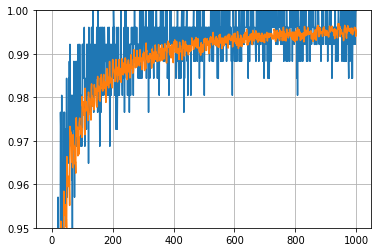

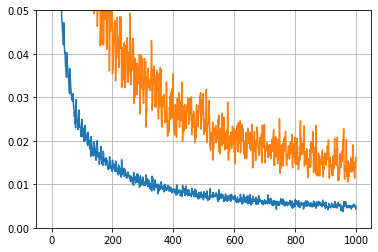

In [27]:
# acc, blue : train, yellow : test
plt.figure(1)
plt.grid()
plt.plot(train_acc_ls)
plt.plot(ta)
plt.ylim(0.95, 1.0)

# loss, blue : train, yellow : test
plt.figure(2)
plt.grid()
plt.plot(train_loss_ls)
plt.plot(tl)
plt.ylim(0., 0.05)

In [30]:
# 학습 모델 저장 
torch.save(model, '/Users/waterpurifier/TextClassification_CNN/v2.pt')